In [13]:
from os import listdir
from collections import defaultdict
from math import comb, ceil

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

sns.set()

# RUN DATA

## AMD:

Model name:          AMD EPYC 7452 32-Core Processor

Kernel: 4.18.0-372.9.1.el8.x86_64

## Intel:

Model name:          Intel(R) Xeon(R) CPU E7-8890 v4 @ 2.20GHz

Kernel: 4.18.0-348.2.1.el8_5.x86_64

In [17]:
di = "res/intel/"
checksums = {}

for fn in listdir(di):
    if "zip" in fn:
        continue
    acc = 0
    ran = 0
    sel = 0
    with open(di + fn) as inf:
        for l in inf:
            if "access_check" in l:
                acc = int(l.split()[-1])
            elif "rank_check" in l:
                ran = int(l.split()[-1])
            elif "select_check" in l:
                sel = int(l.split()[-1])
    ds = fn.split('_')[-1]
    if ds not in checksums:
        checksums[ds] = [(fn, acc, ran, sel)]
    else:
        checksums[ds].append((fn, acc, ran, sel))

for ds, tups in checksums.items():
    print("======", ds, "=======")
    acc = defaultdict(int)
    ran = defaultdict(int)
    sel = defaultdict(int)
    for t in tups:
        acc[t[1]] += 1
        ran[t[2]] += 1
        if "HYB" not in t[0]:
            sel[t[3]] += 1
    acc_c = sorted(acc.items(), key=lambda x: -x[1])[0][0]
    ran_c = sorted(ran.items(), key=lambda x: -x[1])[0][0]
    sel_c = sorted(sel.items(), key=lambda x: -x[1])[0][0]
    print(acc_c, ran_c, sel_c)
    for t in tups:
        if t[1] != acc_c:
            print(t)
            continue
        if t[2] != ran_c:
            print(t)
            continue
        if "HYB" not in t[0] and t[3] != sel_c:
            print(t)

====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 10455494726011306, 10455494726011306)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 43290239141063738
('HYBRRR_256_32_WT-DNA-1GB.txt', 5826645, 22782127590998922, 22782127590998922)
====== WT-WEB-1GB.txt =======
5288645 23338635564356618 42481085257560706
('HYBRRR_256_32_WT-WEB-1GB.txt', 5288026, 23338635551616740, 23338635551616740)


In [77]:
stuff = []
for machine in ["amd", "intel"]:
    di = f"res/{machine}/"
    for fn in listdir(di):
        if "zip" in fn:
            continue
        d = {}
        with open(di + fn) as inf:
            for l in inf:
                if "access_time" in l:
                    d["access"] = float(l.split()[-1])
                elif "plain_size" in l:
                    d["elems"] = float(l.split()[-1])
                elif "rank_time" in l:
                    d["rank"] = float(l.split()[-1])
                elif "select_time" in l and "HYB" not in fn:
                    d["select"] = float(l.split()[-1])
                elif "rrr_size" in l:
                    d["size_bytes"] = float(l.split()[-1])
        fn_arr = fn.split('_')
        d["data_set"] = fn_arr[-1]
        d["type"] = fn_arr[0]
        d["block_size"] = fn_arr[1]
        if "GAP" in fn:
            d["gap_size"] = fn_arr[3]
        d["OPT"] = False if "NOOPT" in fn else True
        d["machine"] = machine
        if d["type"] == "SDSL" and d["block_size"] == "256":
            continue
        stuff.append(d)

df = pd.DataFrame.from_dict(stuff)

In [71]:
testset = "intel"

In [25]:
set(df["type"])

{'H0GAP', 'H0I', 'H0R', 'H0WDBS', 'HYBIT', 'HYBRRR', 'HYBSDSL', 'RRR', 'SDSL'}

/tmp/ipykernel_11406/4168726133.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sdf = df[df["machine"] == testset][df["type"].isin(["H0GAP", "RRR", "H0WDBS"])]
/tmp/ipykernel_11406/4168726133.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "15"]
/tmp/ipykernel_11406/4168726133.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "24"]
/tmp/ipykernel_11406/4168726133.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "15"]
/tmp/ipykernel_11406/4168726133.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "24"]
/tmp/ipykernel_11406/4168726133.py:7: UserWarning: Boolean Series key will be reindexed to mat

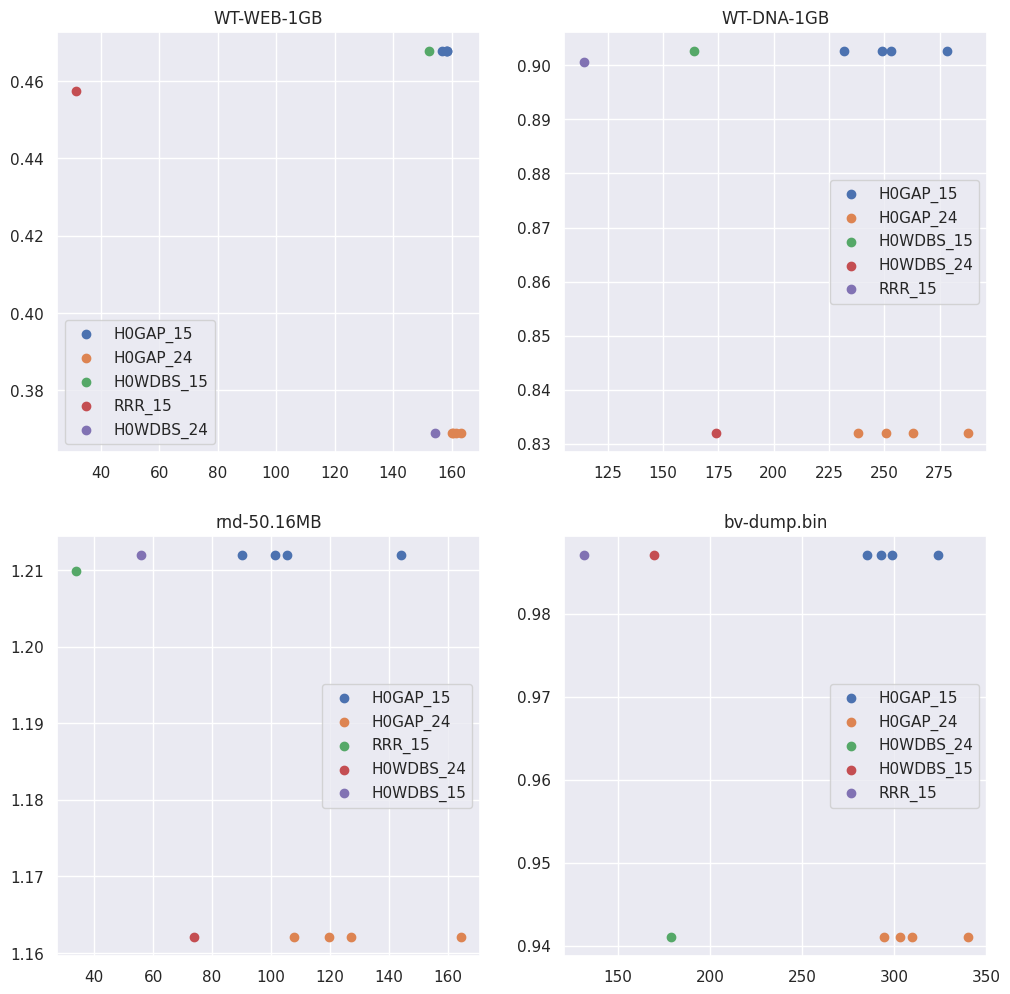

In [72]:
files = set(df["data_set"])
sdf = df[df["machine"] == testset][df["type"].isin(["H0GAP", "RRR", "H0WDBS"])]
plt.figure(figsize=(12, 12))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "15"]
    legs = ["H0GAP_15"]
    sdat = sorted([(g, t, s / e) for g, t, s, e in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])])
    plt.scatter([t[1] for t in sdat], [t[2] for t in sdat])
    tdf = ddf[ddf["type"] == "H0GAP"][ddf["block_size"] == "24"]
    legs.append("H0GAP_24")
    sdat = sorted([(g, t, s / e) for g, t, s, e in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])])
    plt.scatter([t[1] for t in sdat], [t[2] for t in sdat])
    tdf = ddf[ddf["type"].isin(["RRR", "H0WDBS"])]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        plt.scatter([a], [s / e])
        legs.append(f"{t}_{b}")
    plt.legend(legs)
    plt.title(dat[:-4])
plt.savefig(f"lookup_tables_{testset}.png")
plt.show()

/tmp/ipykernel_11406/1130497828.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sdf = df[df["machine"] == testset][df["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR', 'SDSL'])]
/tmp/ipykernel_11406/1130497828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == True]
/tmp/ipykernel_11406/1130497828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == True]
/tmp/ipykernel_11406/1130497828.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == False]
/tmp/ipykernel_11406/1130497828.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == False]
/tmp/ipykernel_11406/1130497828.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame ind

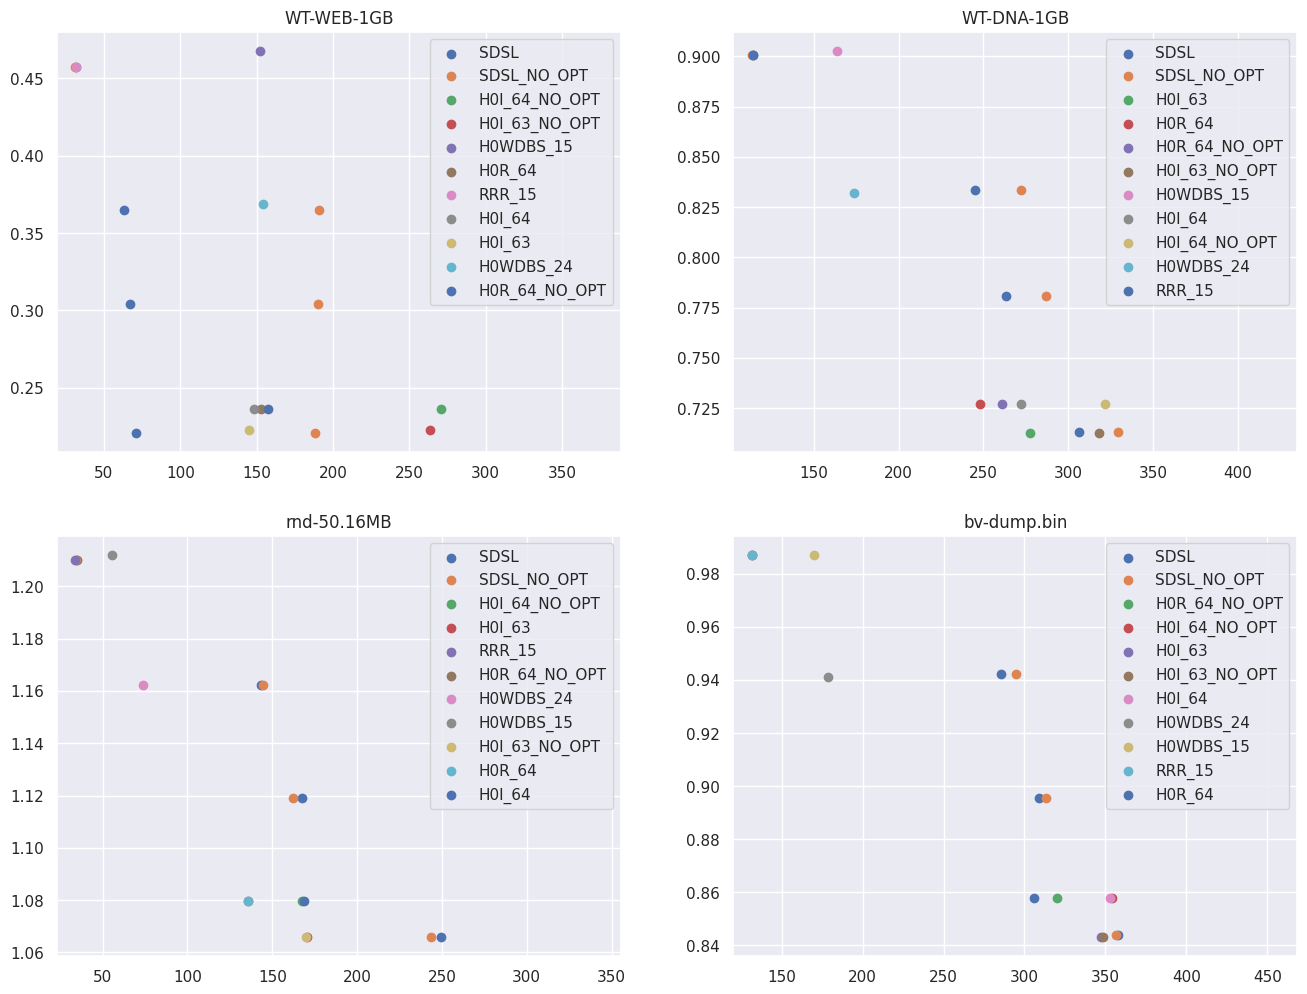

In [81]:
files = set(df["data_set"])
sdf = df[df["machine"] == testset][df["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR', 'SDSL'])]
plt.figure(figsize=(16, 12))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    legs = []
    tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == True]
    sdat = [(b, a, s / e) for a, s, e, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["block_size"])]
    plt.scatter([t[1] for t in sdat], [t[2] for t in sdat])
    legs.append("SDSL")
    tdf = ddf[sdf["type"] == "SDSL"][sdf["OPT"] == False]
    sdat = [(b, a, s / e) for a, s, e, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["block_size"])]
    plt.scatter([t[1] for t in sdat], [t[2] for t in sdat])
    legs.append("SDSL_NO_OPT")
    tdf = ddf[sdf["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR'])]
    for a, s, e, t, b, o in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"], tdf["OPT"]):
        plt.scatter([a], [s / e])
        legs.append(f"{t}_{b}{'_NO_OPT' if o == False else ''}")
    plt.legend(legs)
    plt.title(dat[:-4])
    l, r = plt.xlim()
    plt.xlim((l, r + (r - l)/2.5))
plt.savefig(f"mess_{testset}.png")
plt.show()

/tmp/ipykernel_11406/3023674433.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sdf = df[df["machine"] == testset][df["type"].str.contains("HYB")]


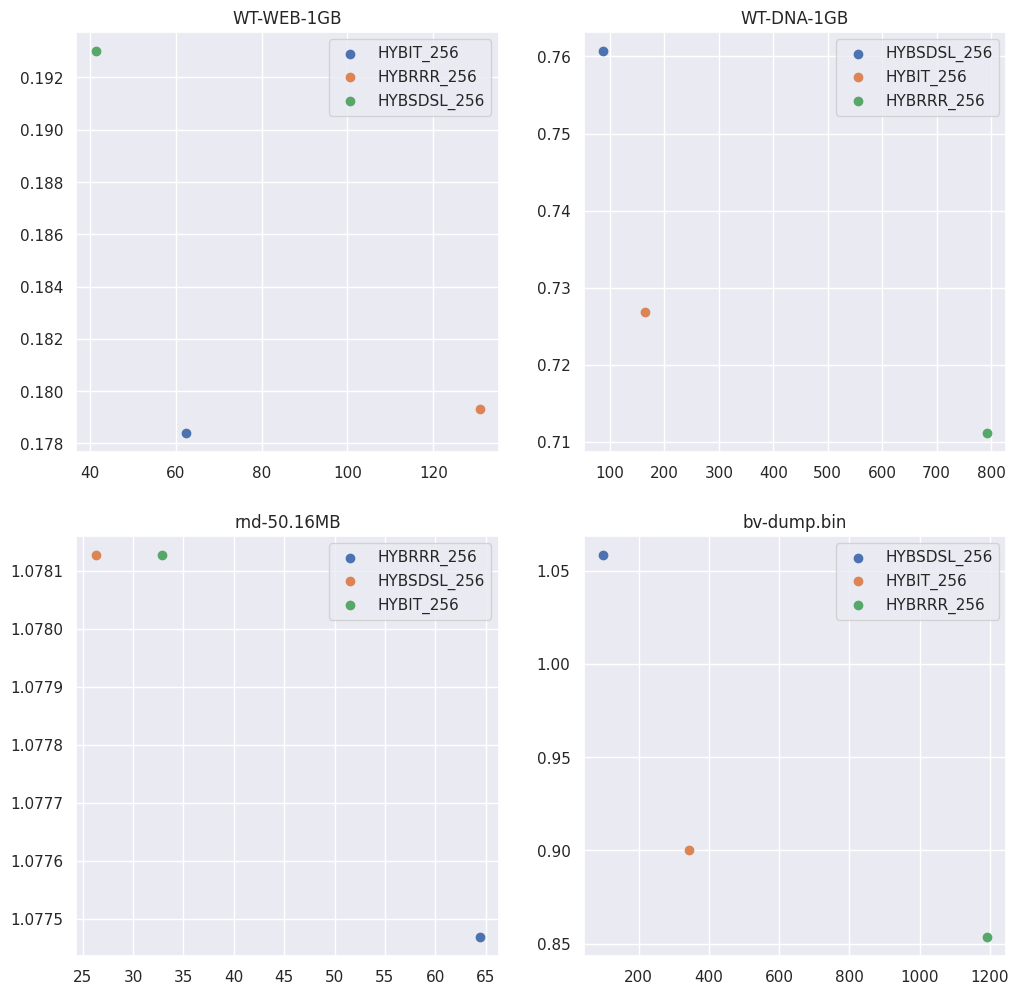

In [74]:
files = set(df["data_set"])
sdf = df[df["machine"] == testset][df["type"].str.contains("HYB")]
plt.figure(figsize=(12, 12))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    legs = []
    for a, s, e, t, b in zip(ddf["access"], ddf["size_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        plt.scatter([a], [s / e])
        legs.append(f"{t}_{b}")
    plt.legend(legs)
    plt.title(dat[:-4])
plt.savefig(f"hybrid_{testset}.png")
plt.show()